<a href="https://colab.research.google.com/github/tombackert/ml-stuff/blob/main/Brain_Tumor_Classification_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification with GradCAM Explanation

# 1. Problem Statement

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob


#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


#---------------------------------------
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#---------------------------------------


import warnings
warnings.filterwarnings("ignore")


# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

## 2. Data Preprocessing

2.1 Load Data

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not founde')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [22]:
# Function for Training Dataframe
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

# Function for Testing Dataframe
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [23]:
# Paths to images
root = '/content/drive/MyDrive/data/grad-cam-data/brain-tumor-mri-dataset/'

# Paths to Traing and Testset
tr_path = root + 'Training'
ts_path = root + 'Testing'

# Defining Traing and Testset
tr_df = train_df(tr_path)
ts_df = test_df(ts_path)

In [25]:
tr_df

,Class Path,Class
0,/content/drive/MyDrive/data/grad-cam-data/brai...,meningioma
1,/content/drive/MyDrive/data/grad-cam-data/brai...,meningioma
2,/content/drive/MyDrive/data/grad-cam-data/brai...,meningioma
3,/content/drive/MyDrive/data/grad-cam-data/brai...,meningioma
4,/content/drive/MyDrive/data/grad-cam-data/brai...,meningioma
...,...,...
5837,/content/drive/MyDrive/data/grad-cam-data/brai...,pituitary
5838,/content/drive/MyDrive/data/grad-cam-data/brai...,pituitary
5839,/content/drive/MyDrive/data/grad-cam-data/brai...,pituitary
5840,/content/drive/MyDrive/data/grad-cam-data/brai...,pituitary


In [26]:
ts_df

,Class Path,Class
0,/content/drive/MyDrive/data/grad-cam-data/brai...,notumor
1,/content/drive/MyDrive/data/grad-cam-data/brai...,notumor
2,/content/drive/MyDrive/data/grad-cam-data/brai...,notumor
3,/content/drive/MyDrive/data/grad-cam-data/brai...,notumor
4,/content/drive/MyDrive/data/grad-cam-data/brai...,notumor
...,...,...
1306,/content/drive/MyDrive/data/grad-cam-data/brai...,pituitary
1307,/content/drive/MyDrive/data/grad-cam-data/brai...,pituitary
1308,/content/drive/MyDrive/data/grad-cam-data/brai...,pituitary
1309,/content/drive/MyDrive/data/grad-cam-data/brai...,pituitary


In [37]:
# Count of images in each class
def count_images(df):
  plt.figure(figsize=(15,7))
  ax = sns.countplot(data=df, y=df['Class'], palette='rocket')

  plt.xlabel('')
  plt.ylabel('')
  plt.title('Count of images in each class')
  ax.bar_label(ax.containers[0])
  plt.show()

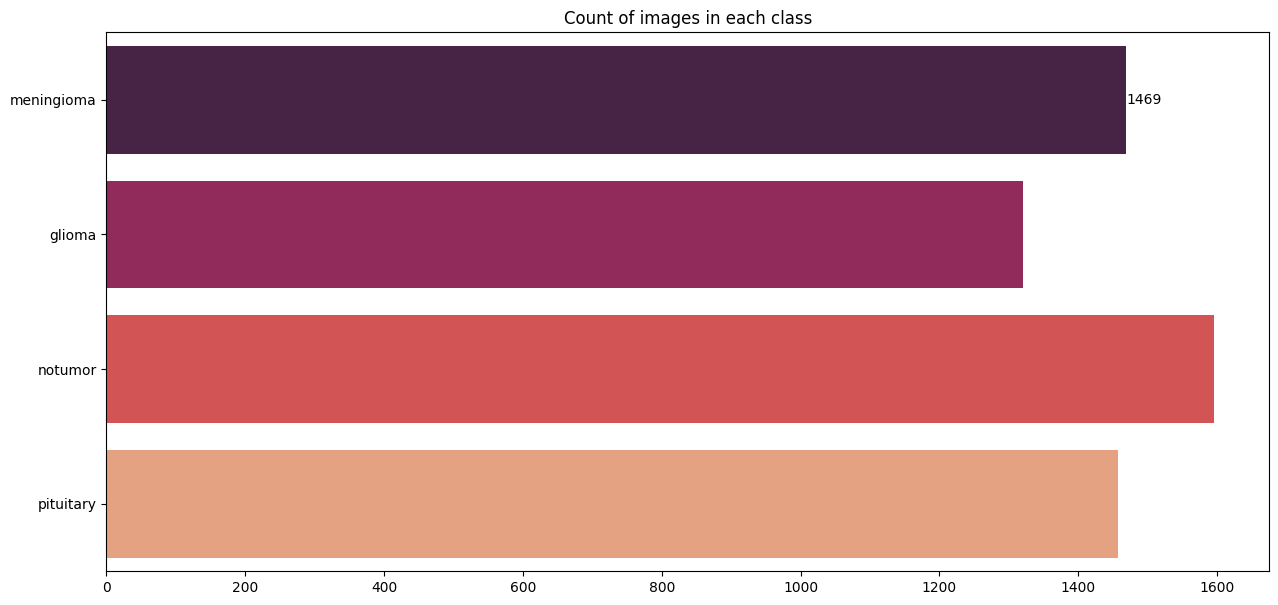

In [38]:
count_images(tr_df)

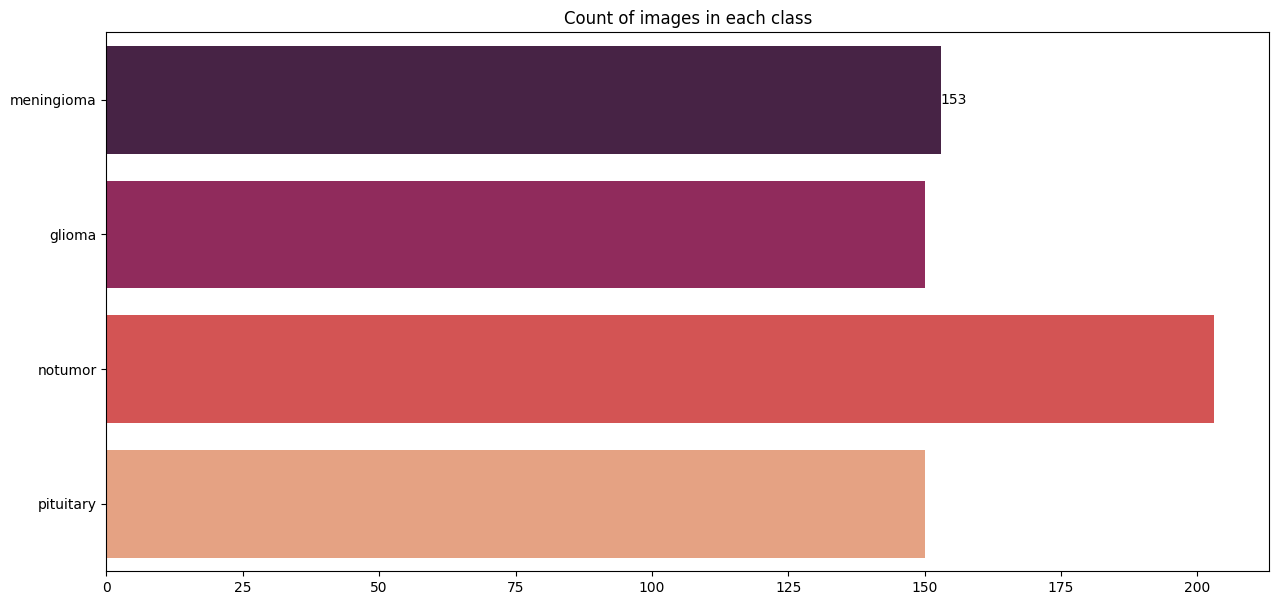

In [39]:
count_images(ts_df)

## 2.2 Splitting Data into Train, Test and Validationsets

In [34]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [35]:
valid_df

,Class Path,Class
997,/content/drive/MyDrive/data/grad-cam-data/brai...,glioma
423,/content/drive/MyDrive/data/grad-cam-data/brai...,meningioma
1072,/content/drive/MyDrive/data/grad-cam-data/brai...,pituitary
478,/content/drive/MyDrive/data/grad-cam-data/brai...,meningioma
820,/content/drive/MyDrive/data/grad-cam-data/brai...,glioma
...,...,...
770,/content/drive/MyDrive/data/grad-cam-data/brai...,glioma
254,/content/drive/MyDrive/data/grad-cam-data/brai...,notumor
984,/content/drive/MyDrive/data/grad-cam-data/brai...,glioma
599,/content/drive/MyDrive/data/grad-cam-data/brai...,meningioma


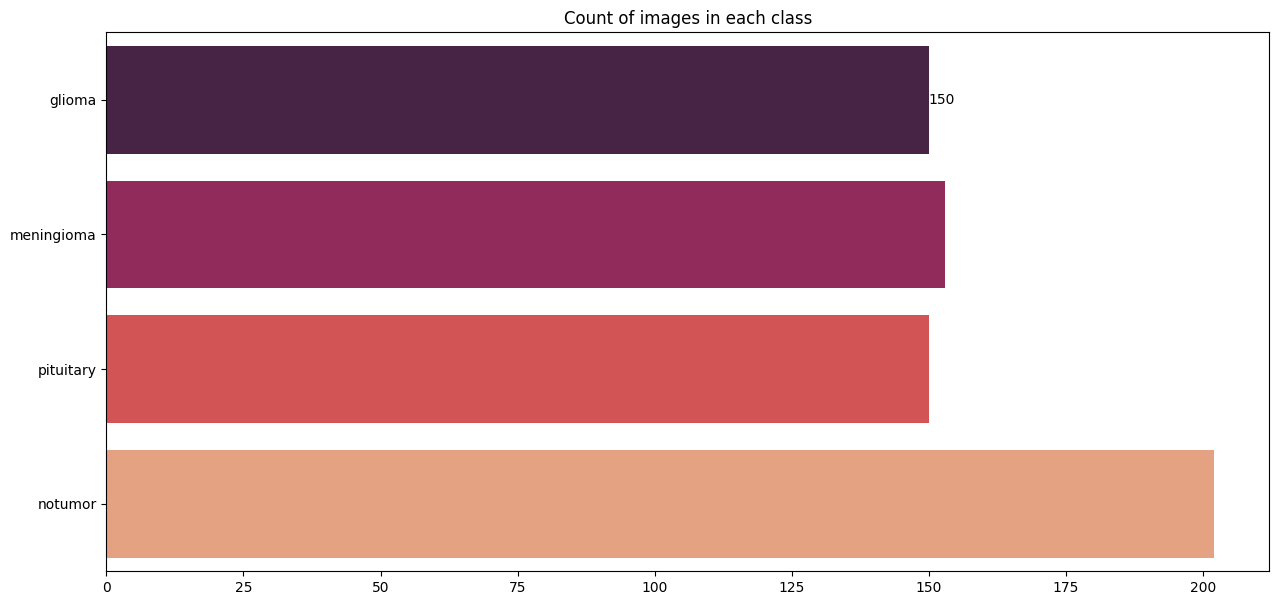

In [40]:
count_images(valid_df)

## 2.3 Data Preprocessing

In [41]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5842 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4 Getting Samples from Data

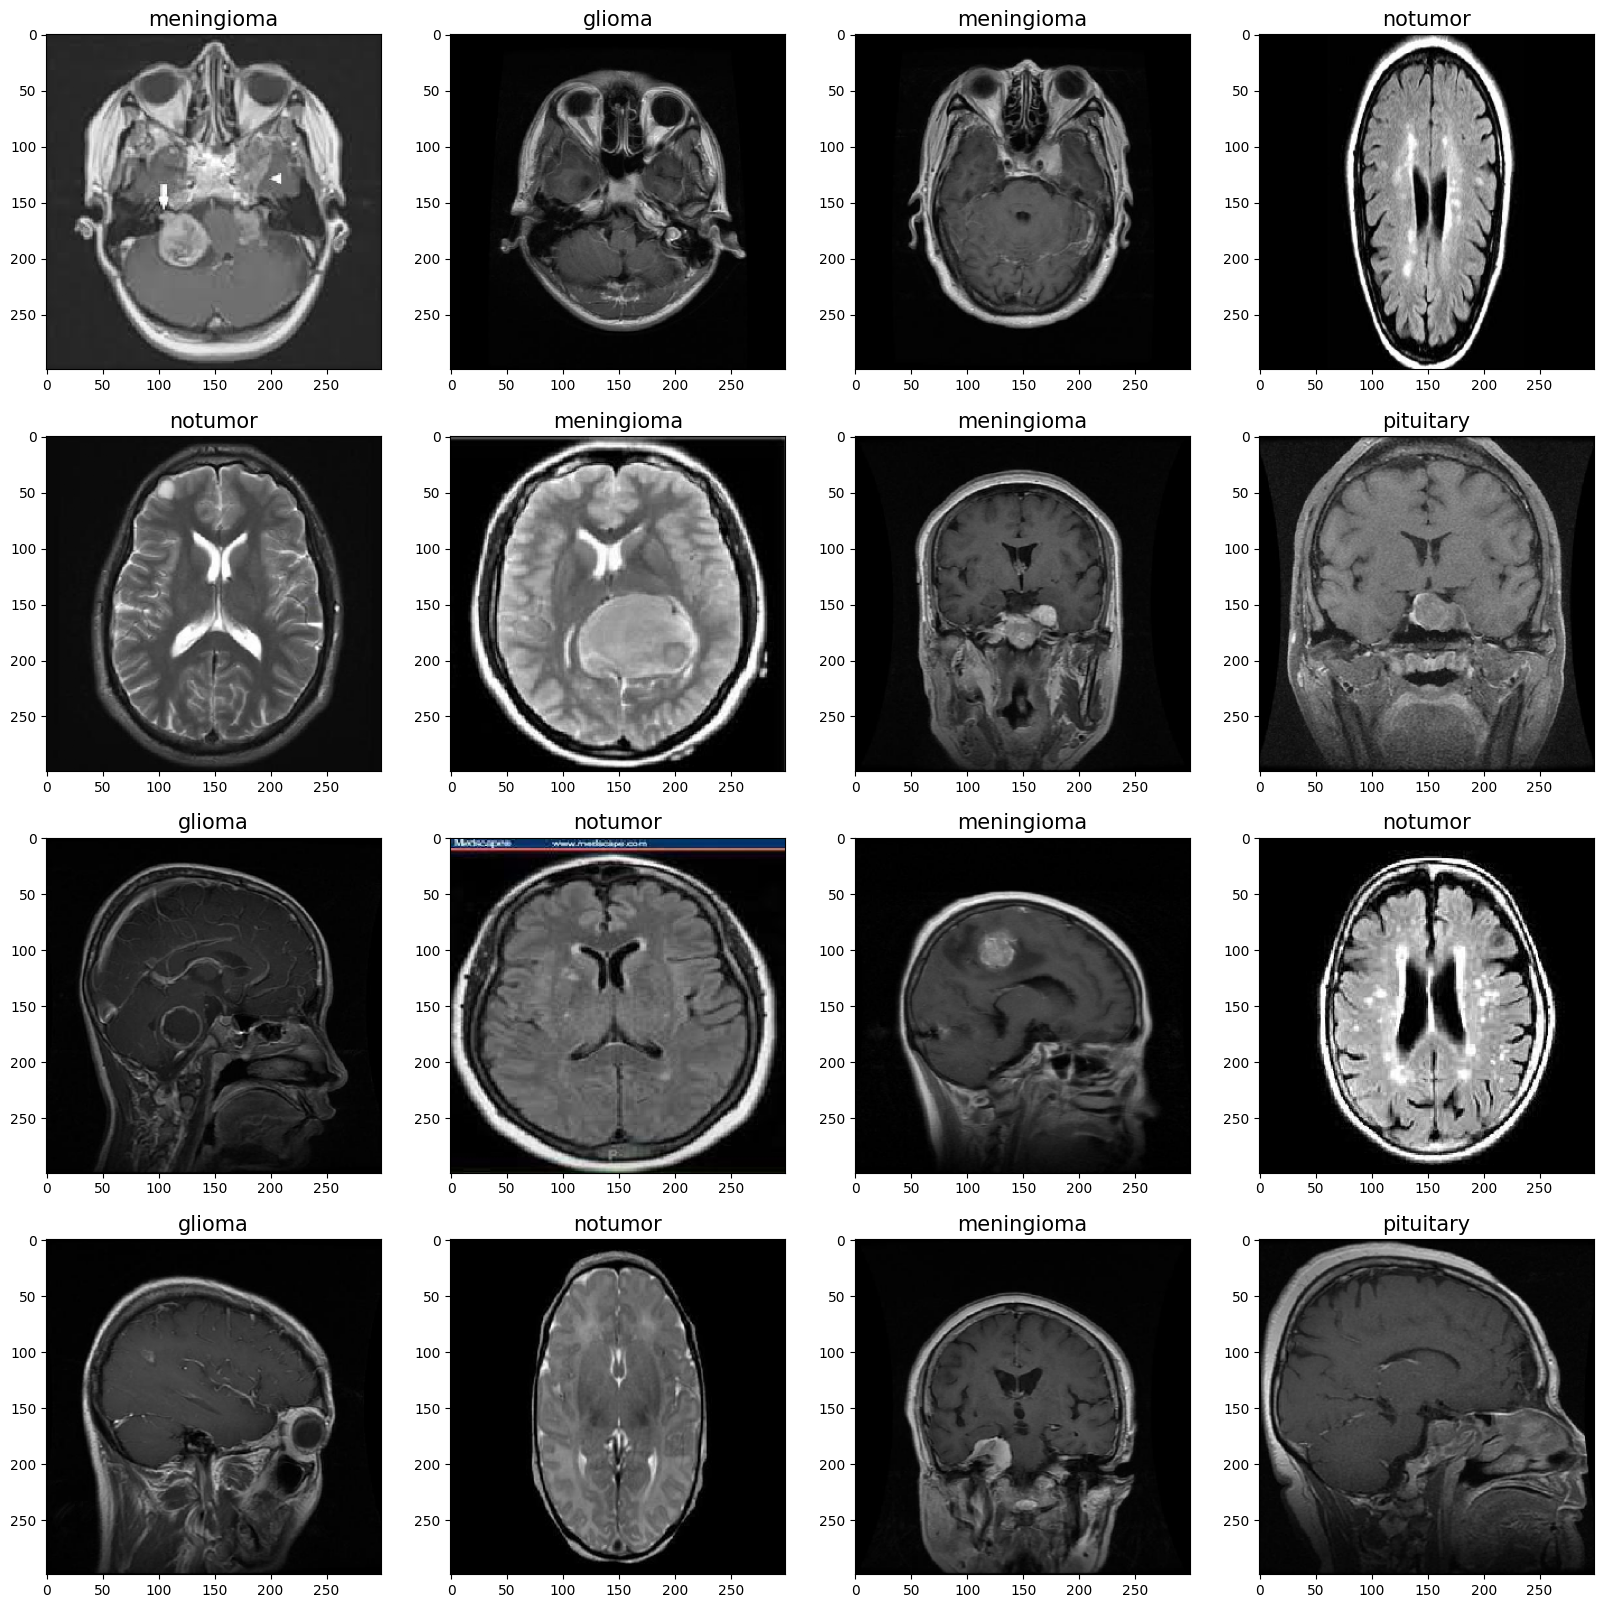

In [42]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Model

In [51]:

img_shape = (299,299,3)
base_model = tf.keras.applications.Xception(include_top=False,
                                            weights="imagenet",
                                            input_shape=img_shape,
                                            pooling='max')

# Model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 21

In [52]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

In [53]:
# choose last convolutional layer
last_conv_layer_name = 'block14_sepconv2_act'
last_conv_layer = base_model.get_layer(last_conv_layer_name)

# 4. Model Training

In [55]:
with tf.device(device_name):
  hist = model.fit(tr_gen,
                   epochs=10,
                   validation_data=valid_gen,
                   shuffle=False)

Epoch 1/10
183/183 [==============================] - 4648s 26s/step - loss: 0.2203 - accuracy: 0.9284 - precision_1: 0.9372 - recall_1: 0.9175 - val_loss: 0.4656 - val_accuracy: 0.8122 - val_precision_1: 0.8166 - val_recall_1: 0.8092
Epoch 2/10
183/183 [==============================] - 165s 903ms/step - loss: 0.0512 - accuracy: 0.9851 - precision_1: 0.9864 - recall_1: 0.9843 - val_loss: 0.1155 - val_accuracy: 0.9649 - val_precision_1: 0.9648 - val_recall_1: 0.9618
Epoch 3/10
183/183 [==============================] - 169s 921ms/step - loss: 0.0282 - accuracy: 0.9918 - precision_1: 0.9921 - recall_1: 0.9916 - val_loss: 0.0437 - val_accuracy: 0.9786 - val_precision_1: 0.9786 - val_recall_1: 0.9786
Epoch 4/10
183/183 [==============================] - 165s 900ms/step - loss: 0.0197 - accuracy: 0.9945 - precision_1: 0.9949 - recall_1: 0.9944 - val_loss: 0.0690 - val_accuracy: 0.9802 - val_precision_1: 0.9802 - val_recall_1: 0.9802
Epoch 5/10
183/183 [==============================] - 167

In [56]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

## 4.1 Visualizing Model Performance

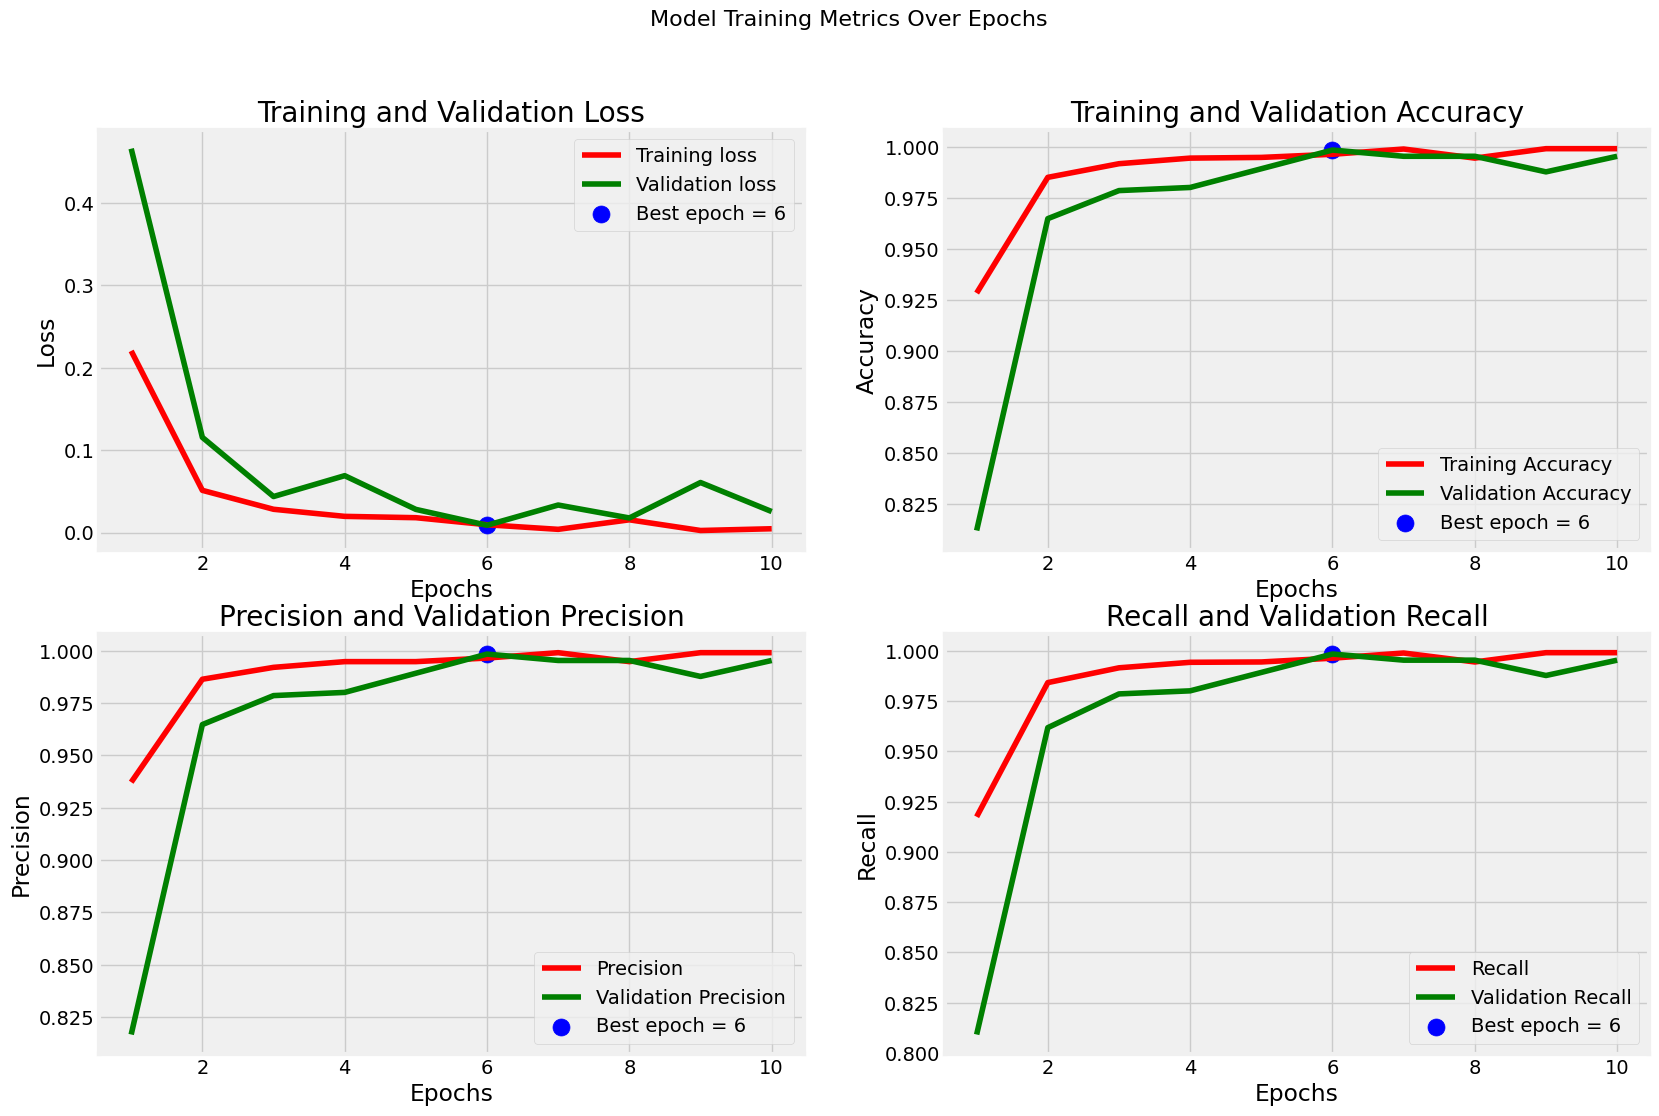

In [58]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision_1']
tr_recall = hist.history['recall_1']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision_1']
val_recall = hist.history['val_recall_1']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# 5. Testing and Evaluating Model

## 5.1 Model Eval

- Checking for false positives and false negatives

In [59]:
tr_gen_copy = tr_gen
valid_gen_copy = valid_gen
ts_gen_copy = ts_gen

In [1]:



train_score = model.evaluate(tr_gen_copy, verbose=1)
valid_score = model.evaluate(valid_gen_copy, verbose=1)
test_score = model.evaluate(ts_gen_copy, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

NameError: name 'model' is not defined

In [ ]:
preds = model.predict(ts_gen_copy)
y_pred = np.argmax(preds, axis=1)

In [ ]:
# Confusion Matrix
cm = confusion_matrix(ts_gen_copy.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen_copy.classes, y_pred)
print(clr)

## 5.2 Testing Model on Testdata

In [ ]:
def predict(img_path):
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

# 6. Applying GradCAM

In [ ]:
# Building same Model as before but with last convolutional layer as output
gradcam_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")

    jet_heatmap = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_heatmap[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image(cam_path))


In [ ]:

# Load and preprocess a sample image
img_path = "path_to_image.jpg"
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.xception.preprocess_input(img_array)

# Create gradcam heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display gradcam
display_gradcam(img_path, heatmap)